In [1]:
from libaries import *
from data_loading import findFiles,LoadDataSignals
from global_parameters import *
from peak_to_peak_detection import *
from Data_Denoising.data_denoising import *
from Data_Denoising.time_synchronization import *
from Data_Denoising.moving_average_filter import *
from Data_Denoising.derivative_filtering import apply_improved_derivative_filter
from Data_Denoising.dc_offset_removal import *
from plotting_module.signal_plot import *
from Data_Denoising.bandpass_filtering import *
from waveform_detection.detect_waveform import *
from waveform_detection.pan_algorithm import *
from time_of_flight_calculation.zero_crossings import *


In [2]:
import os
print(os.listdir())

['libaries.py', 'hanning_7tap.png', 'hanning_smoothing_passes.png', 'uniform_moving_average.png', 'main.ipynb', 'waveform_detection', 'crosstalk_spectrum.png', 'data_loading.py', '__pycache__', 'plotting_module', 'clipped_signal_ns.png', 'peak_to_peak_detection.py', 'global_parameters.py', 'main.py', 'Data_Denoising', 'time_of_flight_calculation']


In [3]:
def normalize_min_max(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


#### Extract relevant files for processing


In [4]:
waveforms=["sin","squ"]
periods= ["1","5","9"]

expected_waveform= waveforms[1]
expected_periods= periods[2]

In [5]:
unique_file_list= findFiles(expected_waveform,expected_periods,sample_number=1)
unique_file_list

144000mg
.DS_Store
108000mg
36000mg
00000mg
18000mg
54000mg
90000mg
72000mg
126000mg


['/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/144000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-144000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/108000mg/28thmaynewsetup1percentage25DegreeTemperatureMarch-ram-WaterSugar_mid_solution-108000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/36000mg/2025may28-ram-WaterSugar_mid_solution-36000mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal processing/dataset/28_May_2025/00000mg/2025may28-ram-WaterSugar_mid_solution-0mg-squ9-pure_water_solution_1.mat',
 '/Users/madhviasthana/Documents/Experimental Signal Preprocessing  /Experimental signal p

## Data Loading

In [6]:
raw,Concentration,actual_waveform,periods=LoadDataSignals(unique_file_list[2],time_axis_start=0,time_axis_end=16000)


raw.shape


(100, 2, 16000)

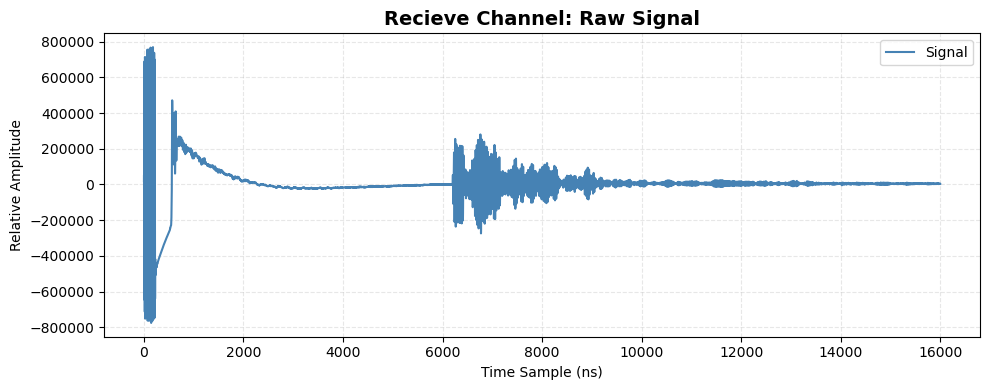

In [7]:
signal_plot(raw[0,1,:],start=0,end=16000,title="Recieve Channel: Raw Signal")

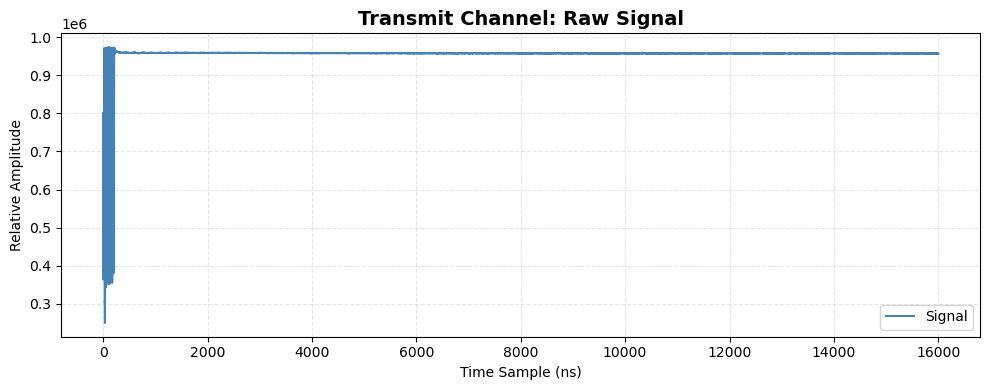

In [8]:
signal_plot(raw[0,0,:],start=0,end=16000,title="Transmit Channel: Raw Signal")

# Data Processing

#### DC offset removal

In [9]:
transmit, receive= dc_offset_removal(raw)

DC Offset Removal - Transmit: (100, 16000)  | Receive: (100, 16000)


Text(0.5, 1.0, 'raw')

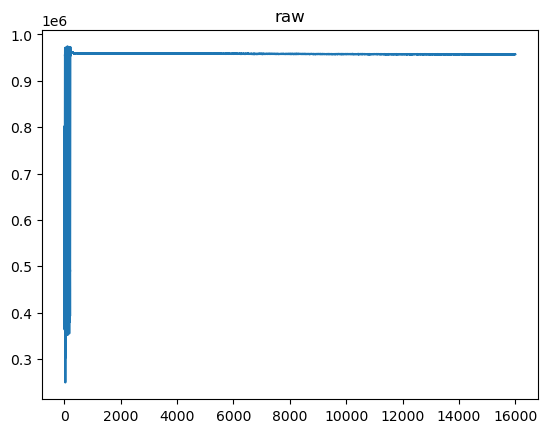

In [10]:
plt.plot(raw[0,0,:])
plt.title("raw")

Text(0.5, 1.0, 'DC offset')

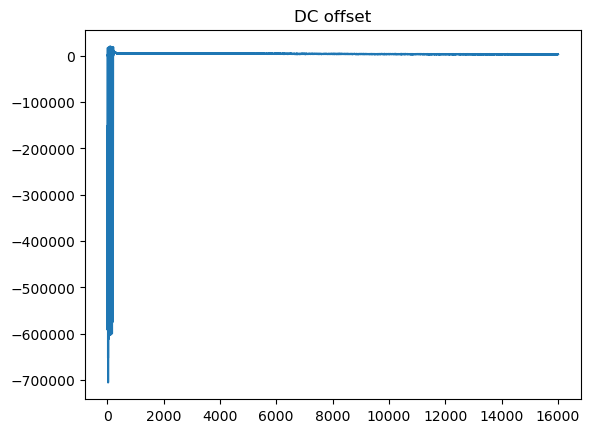

In [11]:
plt.plot(transmit[0])
plt.title("DC offset")

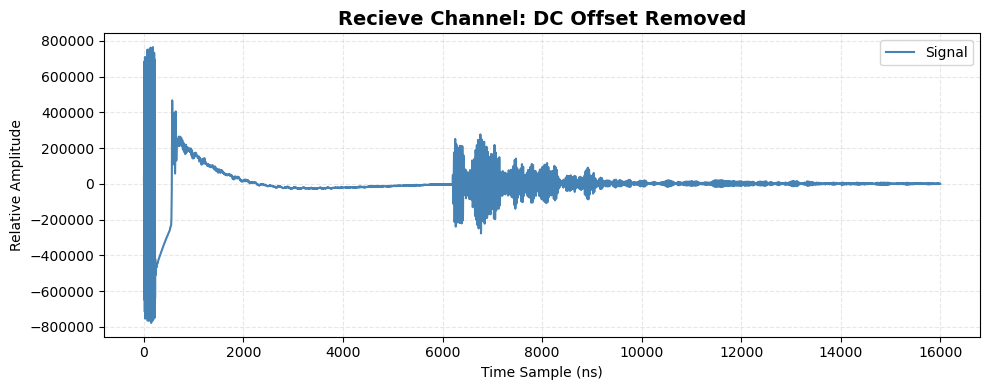

In [12]:
signal_plot(receive[0,:],start=0,end=16000,title="Recieve Channel: DC Offset Removed")

# Different Filtering Techniques in Time Domain

#### Time Synchronized Averaging (Experiments=100)

In [13]:
transmit.shape

(100, 16000)

In [14]:
transmit_averaged_signal,recieve_averaged_signal=time_synchronized_averaging(raw[:,0,:],receive,threshold=500000)

Transmit Valid signals after filtering: (33, 16000)
Recieve Valid signals after filtering: (33, 16000)


In [15]:
recieve_averaged_signal.shape

(1, 16000)

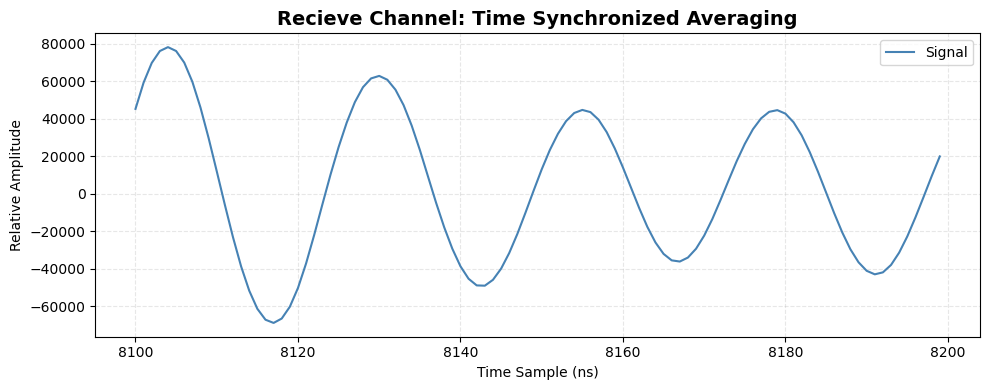

In [16]:
signal_plot(recieve_averaged_signal[0],start=8100,end=8200,title="Recieve Channel: Time Synchronized Averaging")

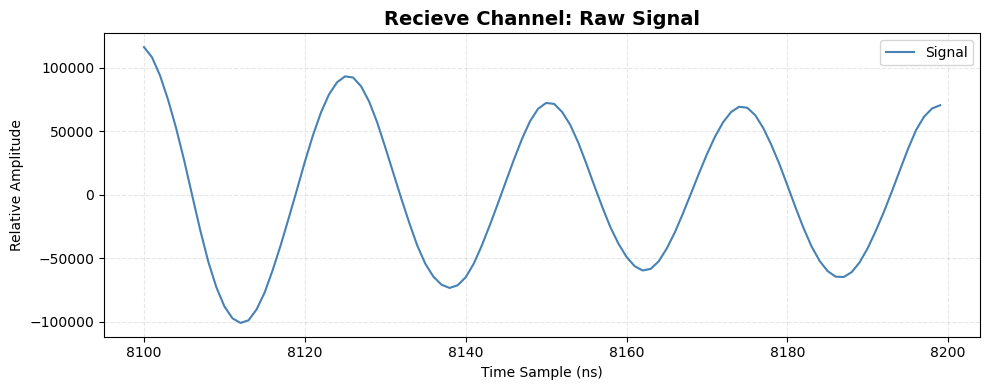

In [17]:
signal_plot(receive[0,:],start=8100,end=8200,title="Recieve Channel: Raw Signal")

#### Moving Average : Hanning filter or Triangular Filter

In [18]:
transmit_filtered_hanning = batch_apply_hanning_filter(transmit)
recieve_filtered_hanning = batch_apply_hanning_filter(receive)

In [19]:
# Print shape to verify
print("Hanning filter Transmit shape:", transmit_filtered_hanning.shape) 
print("Hanning filter Recieve shape:", recieve_filtered_hanning.shape) 

Hanning filter Transmit shape: (100, 16000)
Hanning filter Recieve shape: (100, 16000)


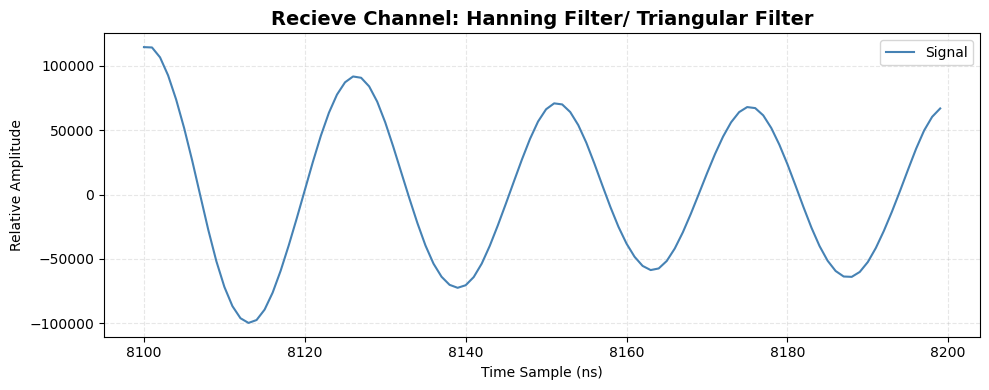

In [20]:
signal_plot(recieve_filtered_hanning[0],start=8100,end=8200,title="Recieve Channel: Hanning Filter/ Triangular Filter")

#### Uniform Moving Average

In [21]:
transmit_uniform_moving_avg=apply_uniform_moving_average_filter(transmit, window_size=11)
recieve_uniform_moving_avg=apply_uniform_moving_average_filter(receive, window_size=11)


In [22]:
recieve_uniform_moving_avg.shape

(100, 16000)

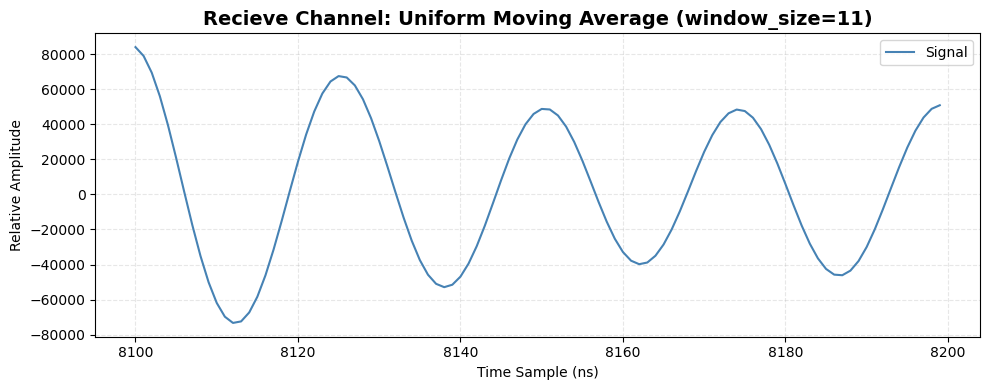

In [23]:
signal_plot(recieve_uniform_moving_avg[0],start=8100,end=8200,title="Recieve Channel: Uniform Moving Average (window_size=11)")

#### Derivative Filter

In [24]:
fs = 125e6  # Sampling frequency in Hz
T = 1 / fs  # Sampling period in seconds

In [25]:
transmit_filtered_derivative=apply_improved_derivative_filter(transmit, T=T)
receive_filtered_derivative=apply_improved_derivative_filter(receive, T=T)


In [26]:
receive_filtered_derivative.shape

(100, 16000)

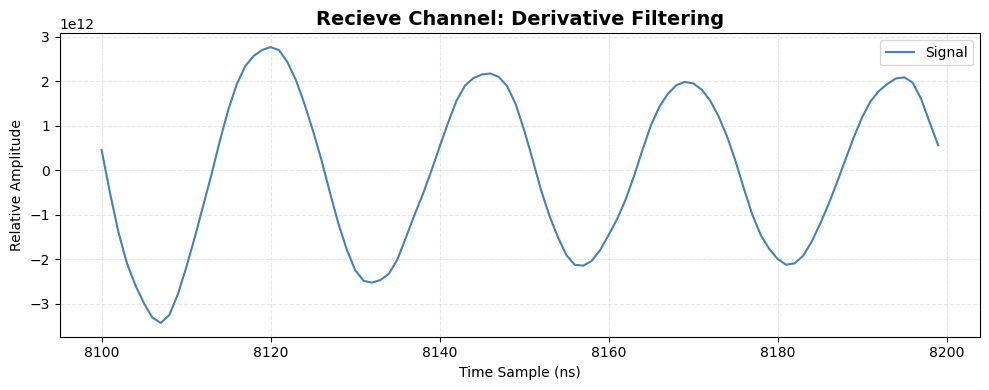

In [27]:
signal_plot(receive_filtered_derivative[0,:],start=8100,end=8200,title="Recieve Channel: Derivative Filtering")

### For smoothning of derivative filter, a uniform average filter is being applied

In [28]:
receive_filtered_derivative_smoothened=apply_uniform_moving_average_filter(receive_filtered_derivative, window_size=11)


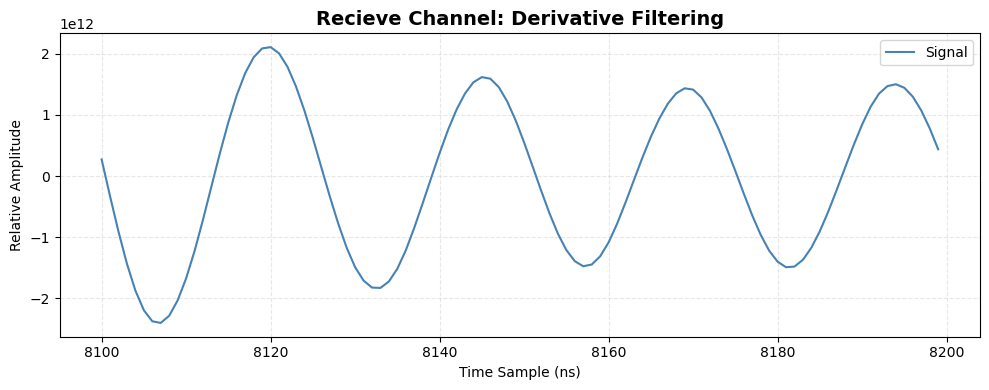

In [29]:
signal_plot(receive_filtered_derivative_smoothened[0,:],start=8100,end=8200,title="Recieve Channel: Derivative Filtering")

#### High Pass Filter

In [30]:

def highpass_filter(data, cutoff, fs, order=5):
    """
    Apply a high-pass Butterworth filter to a 2D signal array.
    """
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    # Design Butterworth high-pass filter
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    # Apply filter to each signal
    filtered_data = filtfilt(b, a, data, axis=1)
    return filtered_data


In [31]:
cutoff = 1_000_000  # 1 MHz
order = 1

recieve_highpass_filtered = highpass_filter(receive, cutoff, fs, order)


In [32]:
recieve_highpass_filtered.shape

(100, 16000)

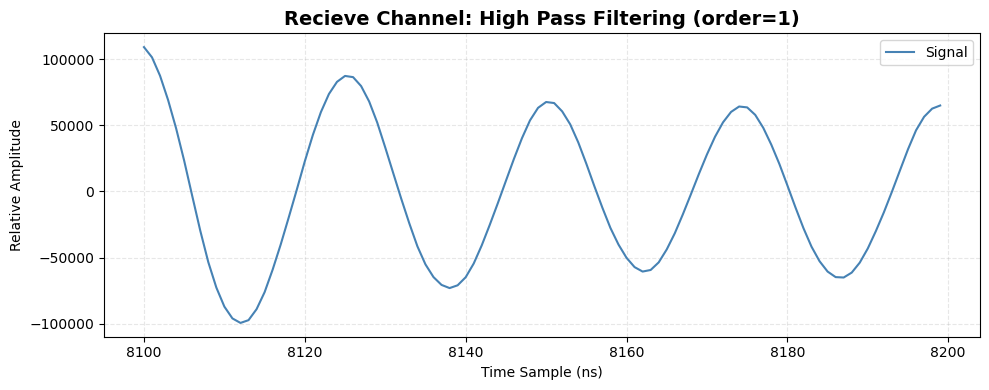

In [33]:
signal_plot(recieve_highpass_filtered[0,:],start=8100,end=8200,title="Recieve Channel: High Pass Filtering (order=1)")

### Bandpass Filter

In [34]:
start=0
end=16000

In [35]:
bandpassed_receive = apply_bandpass_filter(receive[0, start:end], fs, 1e6, 6.5e6)
bandpassed_avg = apply_bandpass_filter(recieve_averaged_signal[0, start:end], fs, 4e6, 6e6)
bandpassed_hanning = apply_bandpass_filter(recieve_filtered_hanning[0, start:end], fs, 4e6, 6e6)


In [36]:
bandpassed_receive.shape

(16000,)

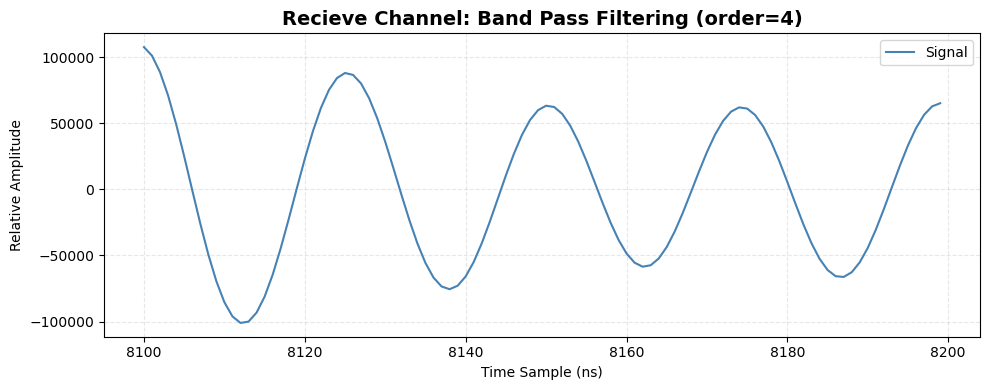

In [37]:

signal_plot(bandpassed_receive[:],start=8100,end=8200,title="Recieve Channel: Band Pass Filtering (order=4)")

#### Data Plotting (For Testing)

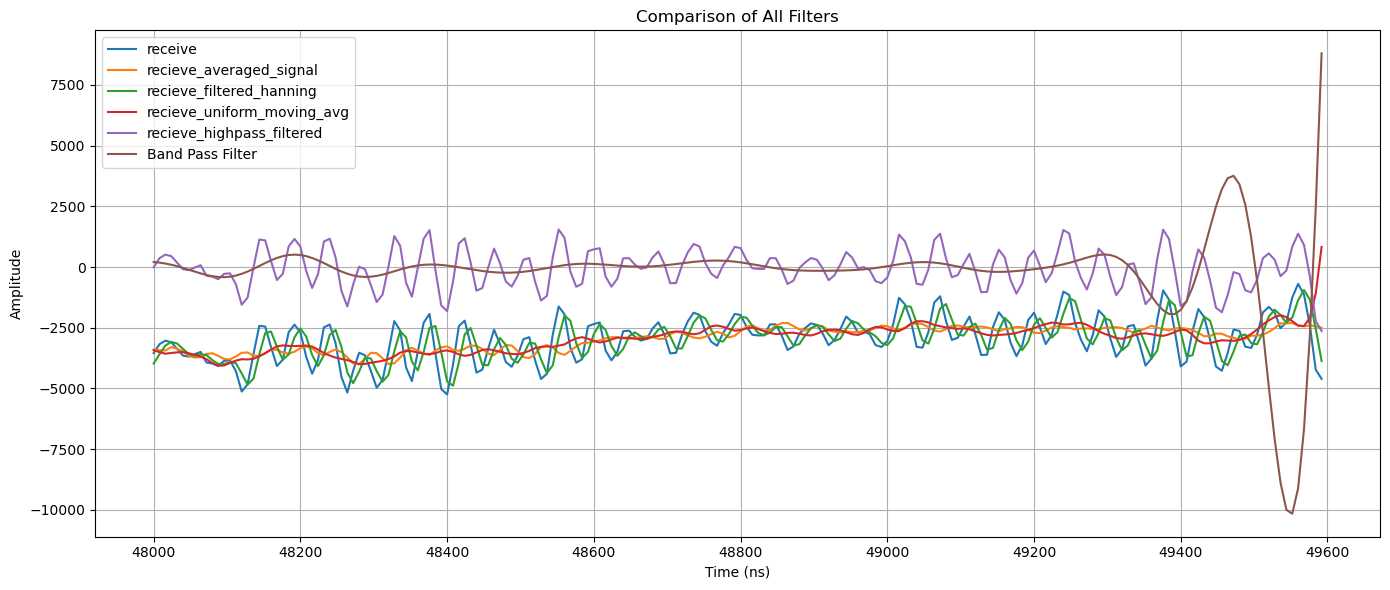

In [38]:
start=0
end=16000
Ts_ns = 1e9 / fs  # Sampling period in nanoseconds
time = np.arange(start, end) * Ts_ns

# Time setup again
zoom_local_start = 6000 - start
zoom_local_end = 6200 - start
zoom_time = time[zoom_local_start:zoom_local_end]

# Scale derivative for fair visual comparison
scaled_derivative = receive_filtered_derivative_smoothened[0, zoom_local_start:zoom_local_end] / 1e12  # Trillions to hundreds

plt.figure(figsize=(14, 6))

plt.plot(zoom_time, receive[0, zoom_local_start + start : zoom_local_end + start], label='receive')
plt.plot(zoom_time, recieve_averaged_signal[0, zoom_local_start:zoom_local_end], label='recieve_averaged_signal')
plt.plot(zoom_time, recieve_filtered_hanning[0, zoom_local_start:zoom_local_end], label='recieve_filtered_hanning')
plt.plot(zoom_time, recieve_uniform_moving_avg[0, zoom_local_start:zoom_local_end], label='recieve_uniform_moving_avg')
plt.plot(zoom_time, recieve_highpass_filtered[0, zoom_local_start:zoom_local_end], label='recieve_highpass_filtered')
plt.plot(zoom_time, bandpassed_receive[zoom_local_start:zoom_local_end], label='Band Pass Filter')


plt.title("Comparison of All Filters")
plt.xlabel("Time (ns)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Echo Detection

### Pan-Tompkins Inspired Pipeline / Pan–Tompkins algorithm


In [39]:
low_cutoff=1e6
high_cutoff=5e6
periods=9

In [40]:
receive.shape

bandpassed_receive = receive[0, start:end]
bandpassed_transmit = transmit[0, start:end]

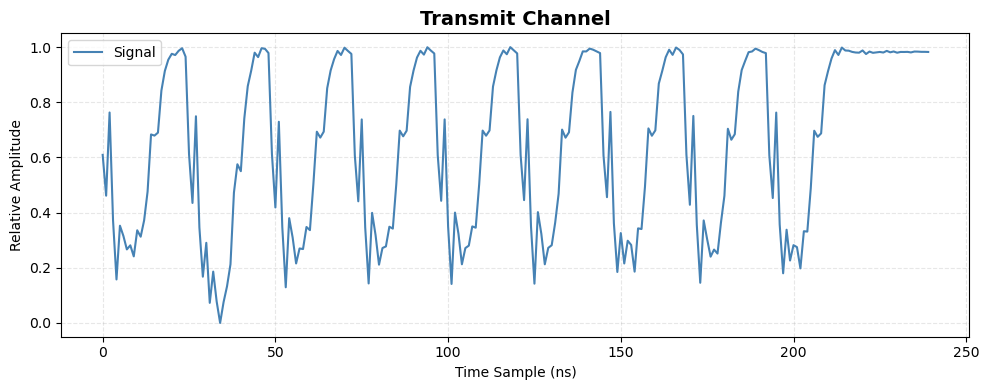

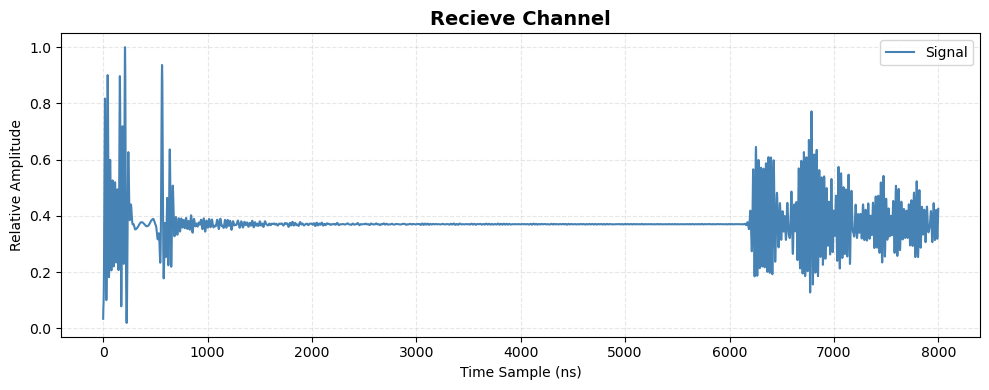

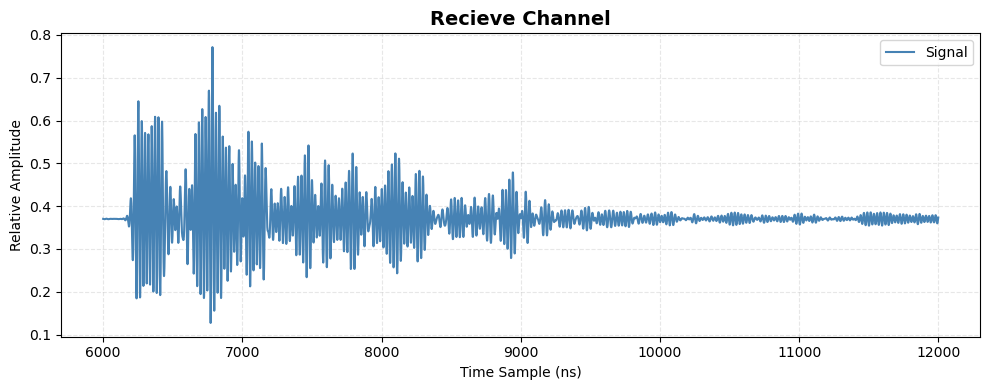

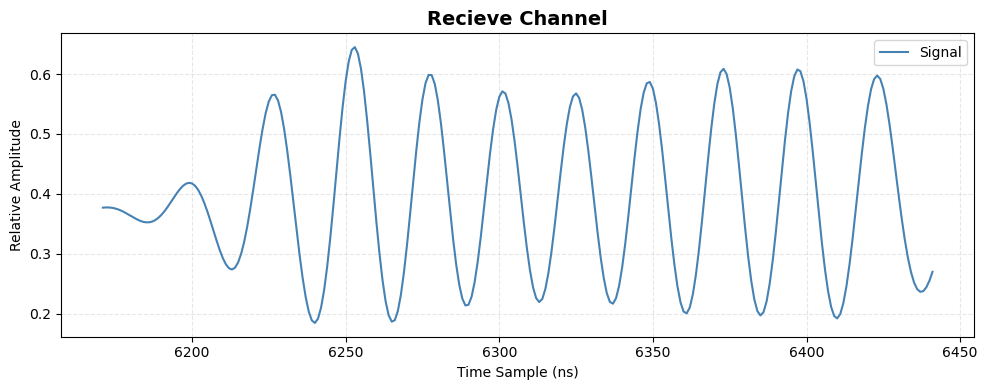

Dynamic Start Threshold: 0.5
Dynamic End Threshold: 0.2
Dynamic Start Threshold: 0.01
Dynamic End Threshold: 0.005
Transmit [(2, 212)]
Recieve [(6185, 9502)]


In [41]:
transmit_echo_list,recieve_echo_list,transmit_min_max_pairs,recieve_min_max_pairs=apply_pan_algorithm(bandpassed_transmit,bandpassed_receive,periods,T,low_cutoff, high_cutoff, order=4, window_size=11,min_prominence=0.05)

# Time of Flight Calculations

In [42]:
from time_of_flight_calculation.zero_crossings import *

In [43]:
transmit.shape

(100, 16000)

In [44]:
bandpassed_receive.shape

(16000,)

In [45]:
# Get the first transmit echo pair
transmit_max_pair = transmit_echo_list[0]

t_start_index = transmit_max_pair[0]
t_amplitude=transmit[0,t_start_index]

max_pair_transmit=(t_start_index,t_amplitude)


# Get the first recieve echo pair
recieve_max_pair = recieve_echo_list[0]

r_start_index = recieve_max_pair[0]
r_amplitude=bandpassed_receive[r_start_index]

max_pair_recieve=(r_start_index,r_amplitude)


#signal_detrended = detrend(transmit[0,:])



zero_crossings = find_next_zero_crossings(transmit[0,:], [t_start_index])





extrema_indices:  [2]
Signal at index 2: -151988.1875 (sign: -1.0)
Signal slice after index 2: [-435590.2 -590615.2 -449417.2 -476408.2 -511678.2 -500953.2 -530021.2]
extrema_index: 2 type: <class 'int'>


In [46]:
zero_crossings

[19.858153475278282]

In [47]:
#signal_detrended = detrend(receive[0,:])


In [48]:
zero_crossings = find_next_zero_crossings(receive[0,:], [r_start_index])
zero_crossings

extrema_indices:  [6185]
Signal at index 2: -133711.8125 (sign: -1.0)
Signal slice after index 2: [ -82218.82 -196973.81 -538068.8  -648030.8  -543318.8  -457222.8
 -486016.8 ]
extrema_index: 6185 type: <class 'int'>


[6201.504097174629]